# Assignement - BioQuants
## Gabriele Galilei 302699

##  Breast Cancer gene expression analysis

Microarray is widely used to monitor gene expression changes in breast cancer. The transcriptomic changes in breast cancer is commonly occured during the transition of normal cells to cancerous cells. This is the first study on gene expression profiling of multi ethnic of Malaysian breast cancer patients (Malays, Chinese and Indian). We aim to identify differentially expressed genes between tumors and normal tissues.

Total RNAs were extracted from breast cancer and normal tissues. Samples were processed and hybridized on the chip for 16 hours. At the end of the study, we obtained a total of 86 set of gene expression data, which were from 43 tumors and 43 normal tissues. The gene expression were then compared between the tumor and normal groups.

### 1 - Dataset

In [1]:
import os
import re
import math
import scipy as sp
import numpy as np
import pandas as pd
import GEOparse
from GEOparse.logger import set_verbosity
set_verbosity("INFO")
import pylab as pl
import networkx as nx
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import gseapy as gp
import networkx as nx
import warnings
from collections import Counter
import statsmodels.stats.multitest as sts
warnings.simplefilter(action = "ignore", category = Warning)

def unique(list1):
    x = np.array(list1)
    return(list(np.unique(x)))

#names = gp.get_library_name()
#with open(r'C:\\Users\\Gabriele Galilei\\Desktop\\PoliTo\\magistrale\\2 ANNO\\BioQuants\\Benso\\libraries.txt', 'w') as fp:
#    for item in names:
#        fp.write("%s\n" % item)

#with open('C:\\Users\\Gabriele Galilei\\Desktop\\PoliTo\\magistrale\\2 ANNO\\BioQuants\\Benso\\libraries.txt') as f:
    #names = f.read().splitlines()
names = ['MSigDB_Hallmark_2020','KEGG_2021_Human']

gse = GEOparse.get_GEO(geo="GSE15852", destdir="./")

03-Feb-2023 10:40:53 INFO GEOparse - File already exist: using local version.
03-Feb-2023 10:40:53 INFO GEOparse - Parsing ./GSE15852_family.soft.gz: 


I used the package $GEOparse$, used to deal with GEO data, and imported the dataset by code of the study.

Then I divided the samples between control group and cancerous group.

In [2]:
for name, extra in gse.gsms.items():
    name = name.strip('\n')
    gse.gsms[name].table.to_csv(name+'.txt',index=None, sep='\t',mode='w')
controls = ['GSM398074.txt','GSM398076.txt','GSM398078.txt','GSM398080.txt','GSM398082.txt','GSM398084.txt','GSM398086.txt','GSM398088.txt','GSM398090.txt','GSM398092.txt','GSM398094.txt','GSM398096.txt','GSM398098.txt','GSM398090.txt',
           'GSM398092.txt','GSM398094.txt','GSM398096.txt','GSM398098.txt','GSM398100.txt','GSM398102.txt','GSM398104.txt','GSM398106.txt','GSM398108.txt','GSM398110.txt','GSM398112.txt','GSM398114.txt','GSM398116.txt','GSM398118.txt',
           'GSM398120.txt','GSM398122.txt','GSM398124.txt','GSM398126.txt','GSM398128.txt','GSM398130.txt','GSM398132.txt','GSM398134.txt','GSM398136.txt','GSM398138.txt','GSM398140.txt','GSM398142.txt','GSM398144.txt','GSM398146.txt',
           'GSM398148.txt','GSM398150.txt','GSM398152.txt','GSM398154.txt','GSM398156.txt','GSM398158.txt']
cancers = ['GSM398075.txt','GSM398077.txt','GSM398079.txt','GSM398081.txt','GSM398083.txt','GSM398085.txt','GSM398087.txt','GSM398089.txt','GSM398091.txt','GSM398093.txt','GSM398095.txt','GSM398097.txt','GSM398099.txt','GSM398091.txt',
           'GSM398093.txt','GSM398095.txt','GSM398097.txt','GSM398099.txt','GSM398101.txt','GSM398103.txt','GSM398105.txt','GSM398107.txt','GSM398109.txt','GSM398111.txt','GSM398113.txt','GSM398115.txt','GSM398117.txt','GSM398119.txt',
           'GSM398121.txt','GSM398123.txt','GSM398125.txt','GSM398127.txt','GSM398129.txt','GSM398131.txt','GSM398133.txt','GSM398135.txt','GSM398137.txt','GSM398139.txt','GSM398141.txt','GSM398143.txt','GSM398145.txt','GSM398147.txt',
           'GSM398149.txt','GSM398151.txt','GSM398153.txt','GSM398155.txt','GSM398157.txt','GSM398159.txt']

Contr = pd.DataFrame()
Canc = pd.DataFrame()
for text in controls:
    filepath = os.path.join("C:\\Users\\Gabriele Galilei\\Desktop\\PoliTo\\magistrale\\2 ANNO\\BioQuants\\Benso\\", text)
    read_file = pd.read_csv(filepath, sep='\t')
    Contr = pd.concat([Contr, read_file["VALUE"]], ignore_index=True, axis=1)
for text in cancers:
    filepath = os.path.join("C:\\Users\\Gabriele Galilei\\Desktop\\PoliTo\\magistrale\\2 ANNO\\BioQuants\\Benso\\", text)
    read_file = pd.read_csv(filepath, sep='\t')
    Canc = pd.concat([Canc, read_file["VALUE"]], ignore_index=True, axis=1)
Contr = Contr.transpose()
Canc = Canc.transpose()
Contr.columns = list(read_file["ID_REF"])
Canc.columns = list(read_file["ID_REF"])
Contr.to_csv('Contr.csv')
Canc.to_csv('Canc.csv')

In [3]:
Contr.head(5)

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-DapX-5_at,...,222375_at,222376_at,222377_at,222378_at,222379_at,222380_s_at,222381_at,222382_x_at,222383_s_at,222384_at
0,136.0530,47.0579,33.0177,299.115,78.2083,103.3220,2282.810,1710.380,3043.37,388.586,...,83.0591,1091.540,389.955,334.248,218.814,1166.000,594.029,144.4710,235.578,109.7310
1,84.9808,45.4352,44.7253,215.668,81.6082,56.8460,2575.820,1926.740,2794.50,342.426,...,87.3889,998.783,226.430,564.187,762.231,1192.480,469.926,45.7619,396.038,271.7270
2,237.2410,59.3774,29.5797,476.853,48.0321,193.5490,2070.450,2033.330,2477.21,305.122,...,114.7920,857.075,236.785,781.606,823.454,1340.190,591.951,190.9180,213.739,242.4240
3,224.4270,59.2154,19.8747,247.148,39.5900,29.3142,387.019,839.148,1346.19,340.555,...,272.2990,793.518,184.601,700.152,610.363,834.485,341.566,81.8431,350.995,153.7190
4,157.5800,36.6432,27.2866,319.710,56.9009,37.6944,1291.740,1210.220,1984.35,321.600,...,412.3940,701.495,228.541,311.069,582.530,608.601,589.227,65.8132,317.106,87.1181


In [4]:
Canc.head(5)

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-DapX-5_at,...,222375_at,222376_at,222377_at,222378_at,222379_at,222380_s_at,222381_at,222382_x_at,222383_s_at,222384_at
0,58.7337,45.7795,12.0183,150.479,61.5917,276.7900,2007.74,1953.41,2388.06,182.222,...,55.5790,903.537,256.895,442.828,308.580,1267.300,287.735,119.8230,213.772,142.793
1,347.8130,49.7853,35.9153,414.494,56.1327,49.8382,1331.01,1920.47,2667.96,141.431,...,88.6138,895.117,364.130,480.780,1133.910,1513.120,557.067,124.8650,302.322,204.338
2,206.7250,50.8069,35.6630,463.839,51.7331,49.9878,1654.57,1604.06,1974.69,242.302,...,71.3126,669.365,204.925,467.984,548.183,1448.020,445.328,250.5380,187.523,336.040
3,339.1850,77.8661,32.3815,287.295,42.0117,208.0580,1611.23,1886.62,2287.96,304.630,...,61.4134,780.279,308.100,526.747,365.646,1938.590,515.614,54.0251,226.247,181.404
4,89.0048,52.8338,15.2770,528.372,91.0708,34.3197,1895.50,1083.52,1500.69,227.929,...,91.7420,1246.230,188.391,534.130,791.749,776.378,456.894,222.9340,356.755,266.435


We can notice how the datasets are the same size of 48 patients for each one is saved the gene expression signal for 22,283 different genes.

### 2 - Dataset quality control
It is important to drop missing values because a big difference in numerosity of different genes can introduce bias in the analysis and affect the reliability of the results.

In [5]:
bool1 = pd.isnull(Contr)
bool2 = pd.isnull(Canc)
freq1 = bool1.sum(axis=1)/bool1.count(axis=1)
freq2 = bool2.sum(axis=1)/bool2.count(axis=1)
print(freq1.sum()/freq1.count())
print(freq2.sum()/freq2.count())

0.0
0.0


None of the elements in the datasets is NaN so we can continue without dropping data.

Then we check for outliers in the marginal distribution of each gene expression signals. So I pronted boxplot to visualize outliers (represented as crosses).

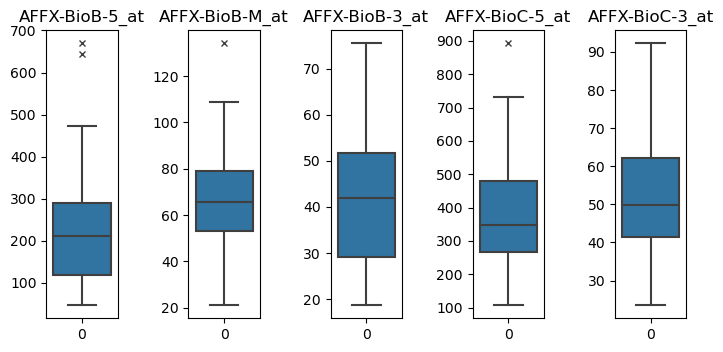

In [6]:
f, axes = plt.subplots(1,5)
plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1.0,
                    top=0.6,
                    wspace=0.99,
                    hspace=0.1)
for itr in range(5):
    sns.boxplot(data=Contr.iloc[:,itr], orient="v", flierprops={"marker": "x"}, ax=axes[itr]).set(title=Contr.columns[itr])
plt.show()

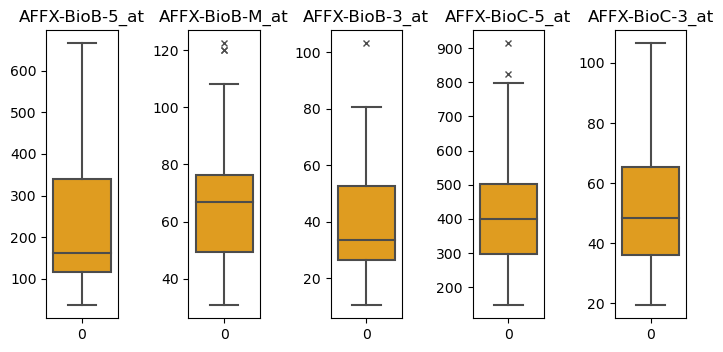

In [7]:
f, axes = plt.subplots(1,5)
plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1.0,
                    top=0.6,
                    wspace=0.99,
                    hspace=0.1)
for itr in range(5):
    sns.boxplot(data=Canc.iloc[:,itr], orient="v", flierprops={"marker": "x"}, color='orange', ax=axes[itr]).set(title=Contr.columns[itr])
plt.show()

In order to discriminate outliers we use the Z-score and eliminate data with Z-score lower then -3.0 or higher then 3.0.

In [8]:
indices1 = []
for itr in range(len(Contr.columns)):
    indtodrop = np.logical_or(sp.stats.zscore(Contr.iloc[:,itr])<-3.0, sp.stats.zscore(Contr.iloc[:,itr])>3.0)
    indices1 = indices1 + list(np.nonzero(np.array(indtodrop)))

In [9]:
indices2 = []
for itr in range(len(Canc.columns)):
    indtodrop = np.logical_or(sp.stats.zscore(Canc.iloc[:,itr])<-3.0, sp.stats.zscore(Canc.iloc[:,itr])>3.0)
    indices2 = indices2 + list(np.nonzero(np.array(indtodrop)))

In [10]:
indices = list(np.hstack(indices1)) + list(np.hstack(indices2))
freq = Counter(indices)
indices = [index for index, visits in freq.items() if visits > 1500]
Contr = Contr.drop(index=indices)
Canc = Canc.drop(index=indices)

To check the results let's plot again marginal boxplots.

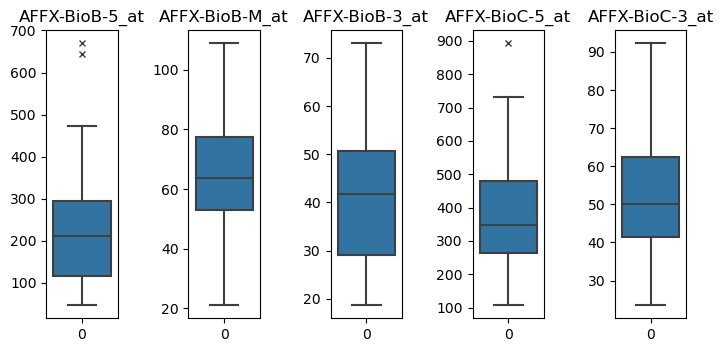

In [11]:
f, axes = plt.subplots(1,5)
plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1.0,
                    top=0.6,
                    wspace=0.99,
                    hspace=0.1)
for itr in range(5):
    sns.boxplot(data=Contr.iloc[:,itr], orient="v", flierprops={"marker": "x"}, ax=axes[itr]).set(title=Contr.columns[itr])
plt.show()

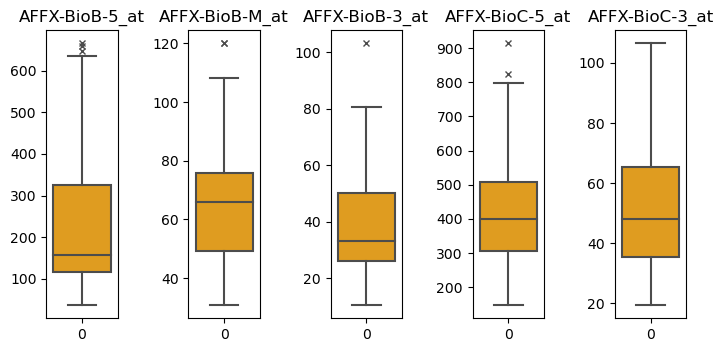

In [12]:
f, axes = plt.subplots(1,5)
plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1.0,
                    top=0.6,
                    wspace=0.99,
                    hspace=0.1)
for itr in range(5):
    sns.boxplot(data=Canc.iloc[:,itr], orient="v", flierprops={"marker": "x"}, color='orange', ax=axes[itr]).set(title=Contr.columns[itr])
plt.show()

### 3 - Statistical Analysis

Now I t-tested the datasets column by columns saving t-statistic and t-values fro each gene.

In [13]:
t_stats = []
t_pvalues = []
for itr in Contr.columns:
    stat, pvalue = sp.stats.ttest_ind(Contr.loc[:,itr], Canc.loc[:,itr], nan_policy='omit')
    t_stats.append(stat)
    t_pvalues.append(pvalue)

In order to check if the difference between gene expression in regular and cancerous tissue is statistically relevant, I ordered them by decreasing t-statistic (difference between means):

In [14]:
t_pvalues = np.array([abs(ele) for ele in t_pvalues])
t_stats = np.array([abs(ele) for ele in t_stats])
rank = list(np.argsort((-1)*t_stats))

and subsequently I remove the genes with a t-value lower than 5% (this would make us accept the null-hypotesis that the samples came from distributions having the same mean):

In [15]:
for ele in rank:
    if ele not in list(np.argwhere(t_pvalues<0.05)):
        rank.remove(ele)
genes = Contr.columns[rank]

Now I plotted the genes with the 10 highest t-statistics in order to have a first hypotesis of the genes involved during cancerization of breast tissue. 

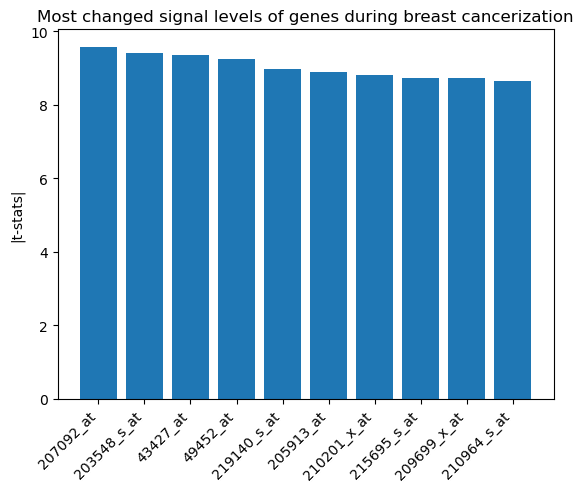

In [16]:
rank = np.array(rank)
x = np.arange(10)
plot = plt.bar(x, height=t_stats[rank[range(10)]])
plot = plt.xticks(x, genes[range(10)], rotation=45, ha="right")
plot = plt.title('Most changed signal levels of genes during breast cancerization')
plot = plt.ylabel('|t-stats|')

For istance:
- $\textbf{207092_at}$ is related to $\textbf{LEPTIN}$: indeed, overexpression of leptin, as determined by staining intensity, is observed in about 92% of breast cancers but in no normal epithelium; (M. Ishikawa, J. Kitayama, H. Nagawa; Enhanced Expression of Leptin and Leptin Receptor (OB-R) in Human Breast Cancer. Clin Cancer Res 1 July 2004; 10 (13): 4325–4331)
- $\textbf{43427_at and 49452_at}$ are related to $\textbf{ACACA and ACACB}$: Overexpression of ACACA has been reported in cancers of the breast, lung, prostate, gliomas and colorectal cancer while low expression of ACACB has been reported in laryngeal squamous cell carcinoma, triple negative breast cancer, retinoblastoma, thyroid and melanoma; (K. Bhattacharjee, M. Nath, Y. Choudhury, Fatty acid synthesis and cancer: Aberrant expression of the ACACA and ACACB genes increases the risk for cancer, Meta Gene, Vol. 26,2020, 100798,ISSN 2214-5400)
- $\textbf{219140_s_at}$ is related to $\textbf{RBP4}$: is a retinol binding protein which low expression implies that Vitamin A action is mitigated in cancer tissues.

Here I adjusted for multiple testing using Benjamini-Hochberg procedure: this is done to limit the false positive error and make results more reliable.

In [17]:
results, corr_pvalues, _, _ = sts.multipletests(t_pvalues[rank], method='fdr_bh', is_sorted=False)
stop = list(results).index(0)

Since my data were collected in Malasya, they were in 'IlluminaTech' coding, not so used in Europe: so I used BioMart to translate them to European standard. The chip used was a 'Affymetrix Human Genome U133A Array' so 'affy_hg_u133a_2''s Biomart was implied to translate to 'external_gene_name'.

In [18]:
results = pd.DataFrame(columns=['affy_hg_u133a_2','external_gene_name'])
corr_genes = list(genes[0:stop-1])
corr_genes = [x.upper() for x in corr_genes]
bm = gp.Biomart()
i = 0
rem = math.inf
corr_genes_tr = []
corr_genes_tr = [str(x) for x in corr_genes_tr]
while i < len(corr_genes) and rem > 100:
    queries ={'affy_hg_u133a_2': corr_genes[i:i+100]}
    resultsitr = bm.query(dataset='hsapiens_gene_ensembl',
                       attributes=['affy_hg_u133a_2', 'external_gene_name'],
                       filters=queries)
    corr_genes_tr = [str(x) for x in corr_genes_tr or unique(list(results["external_gene_name"]))]
    corr_genes_tr = unique(corr_genes_tr)
    corr_genes_tr = [str(x) for x in corr_genes_tr]
    i = i+100
    rem = len(corr_genes) - i
    results = results.append(resultsitr)
queries ={'affy_hg_u133a_2': corr_genes[i:]}
resultsitr = bm.query(dataset='hsapiens_gene_ensembl',
                    attributes=['affy_hg_u133a_2', 'external_gene_name'],
                    filters=queries)
corr_genes_tr = [str(x) for x in corr_genes_tr or unique(list(results["external_gene_name"]))]
corr_genes_tr = unique(corr_genes_tr)
corr_genes_tr = [str(x) for x in corr_genes_tr]
results = results.append(resultsitr)

In [19]:
genes_tr = pd.DataFrame(columns=['not translated','translated'])
genes_tr['not translated'] = genes[0:stop-1]
for itr in range(stop-1):
    if genes_tr.iloc[itr,0] in list(results['affy_hg_u133a_2']):
        n = results[results['affy_hg_u133a_2'] == genes_tr.iloc[itr,0]].index.values
        genes_tr.iloc[itr,1] = results.iloc[n[0],1]
    else:
        genes_tr.iloc[itr,1] = 'nan'

Let's save the obtained ranking for later to use. Usually there are more accurate ranking methods than the t-statistic, but SAM or SAMroc were similar.

In [20]:
ranking = pd.DataFrame(columns = ['gene','ranking'])
ranking['gene'] = genes_tr['translated']
ranking['ranking'] = t_stats[rank[0:stop-1]]
np.savetxt(r'C:\\Users\\Gabriele Galilei\\Desktop\\PoliTo\\magistrale\\2 ANNO\\BioQuants\\Benso\\rank.txt', ranking.values, fmt='%s')

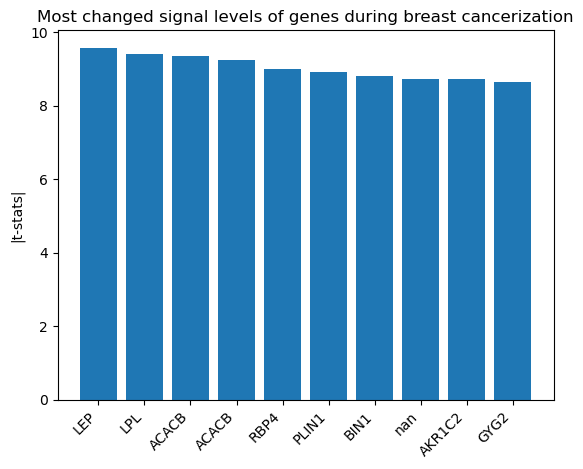

In [21]:
rank = np.array(rank)
x = np.arange(10)
plot = plt.bar(x, height=t_stats[rank[range(10)]])
plot = plt.xticks(x, genes_tr.iloc[range(10),1], rotation=45, ha="right")
plot = plt.title('Most changed signal levels of genes during breast cancerization')
plot = plt.ylabel('|t-stats|')

We can see how nothing changed, only the gene coding.

### 4 - Functional Enrichment analysis
I used the gseapy library to perform enrichment analysis in order to determine whether certain pathways or processes are overrepresented among the differentially expressed genes, suggesting that they may be involved in breast cancer.

For runtime concerns, I collected all the libraries that have useful data in a file called 'libraries.txt'. Subsequently I performed Enrichment Analysis using translated genes.

In [22]:
enr = gp.enrichr(gene_list=corr_genes_tr, gene_sets=names, organism='human', outdir='None')
enr.results.sort_values('Adjusted P-value')

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
33,KEGG_2021_Human,PPAR signaling pathway,10/74,8.151535e-13,9.455781e-11,0,0,40.278003,1121.154330,FABP4;ACADL;ADIPOQ;LPL;PPARG;CD36;ANGPTL4;PLIN...
0,MSigDB_Hallmark_2020,Adipogenesis,12/200,6.608320e-11,2.180746e-09,0,0,16.787234,393.494555,ITIH5;FABP4;ACADL;GPX3;LEP;ADIPOQ;ITSN1;LPL;PP...
1,MSigDB_Hallmark_2020,Myogenesis,8/200,2.583958e-06,4.263531e-05,0,0,10.401371,133.826001,CFD;GPX3;BIN1;FHL1;HSPB2;CD36;SORBS1;COX7A1
34,KEGG_2021_Human,Adipocytokine signaling pathway,5/69,1.251876e-05,5.404636e-04,0,0,18.911014,213.472855,LEP;ADIPOQ;CD36;PCK1;ACACB
35,KEGG_2021_Human,AMPK signaling pathway,6/120,1.397751e-05,5.404636e-04,0,0,12.864847,143.804049,LEP;ADIPOQ;PPARG;CD36;PCK1;ACACB
...,...,...,...,...,...,...,...,...,...,...
144,KEGG_2021_Human,Ras signaling pathway,1/232,6.384295e-01,6.612306e-01,0,0,0.990738,0.444588,GAB2
145,KEGG_2021_Human,Chemical carcinogenesis,1/239,6.494242e-01,6.623881e-01,0,0,0.961257,0.414945,AKR1C2
146,KEGG_2021_Human,Calcium signaling pathway,1/240,6.509676e-01,6.623881e-01,0,0,0.957186,0.410916,CXCR4
147,KEGG_2021_Human,Salmonella infection,1/249,6.645598e-01,6.703385e-01,0,0,0.922027,0.376768,WASF3


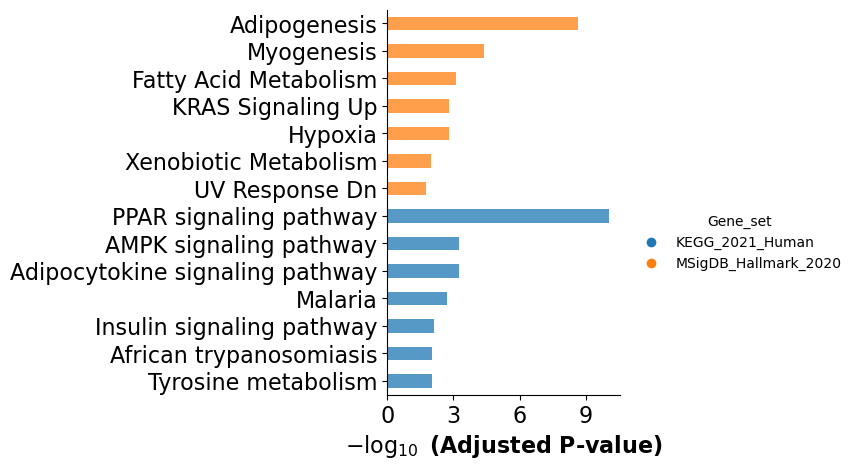

In [23]:
ax = gp.barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set',
              size=100,
              top_term=7,
              figsize=(3,5),
              color=mcolors.TABLEAU_COLORS,
              fontsize=0.5
             )

In [24]:
pre_res = gp.prerank(rnk=ranking,
                     gene_sets=names,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=100,
                     outdir=None,
                     seed=6,
                     verbose=False
                    )

2023-02-03 10:49:40,766 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2023-02-03 10:49:40,777 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


In [25]:
pre_res.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,KEGG_2021_Human__PPAR signaling pathway,0.581823,2.048972,0.0,0.012245,0.01,7/10,21.00%,LPL;PLIN1;FABP4;ANGPTL4;SORBS1;ADIPOQ;CD36
1,prerank,MSigDB_Hallmark_2020__Adipogenesis,0.483423,1.90454,0.0,0.030612,0.05,8/12,28.00%,LEP;LPL;FABP4;ANGPTL4;SORBS1;ADIPOQ;CD36;ITIH5
2,prerank,KEGG_2021_Human__Adipocytokine signaling pathway,0.647639,1.659811,0.044776,0.106122,0.24,4/5,21.00%,LEP;ACACB;ADIPOQ;CD36
3,prerank,KEGG_2021_Human__AMPK signaling pathway,0.606383,1.618552,0.032258,0.097959,0.28,6/6,43.00%,LEP;ACACB;ADIPOQ;CD36;PCK1;PPARG
4,prerank,MSigDB_Hallmark_2020__Xenobiotic Metabolism,0.58842,1.604092,0.08,0.080816,0.29,4/6,21.00%,RBP4;AKR1C2;MAOA;CD36
5,prerank,MSigDB_Hallmark_2020__UV Response Dn,-0.442105,-1.273047,0.121212,0.334247,0.42268,5/5,59.00%,DLC1;PRKAR2B;TGFBR3;CAV1;PPARG
6,prerank,KEGG_2021_Human__Insulin signaling pathway,0.443488,1.158805,0.242857,0.406122,0.83,4/5,41.00%,ACACB;SORBS1;PDE3B;PCK1
7,prerank,MSigDB_Hallmark_2020__Fatty Acid Metabolism,0.414905,1.157457,0.28169,0.351603,0.83,4/7,27.00%,MAOA;CD36;AOC3;G0S2
8,prerank,MSigDB_Hallmark_2020__Myogenesis,0.327224,1.111387,0.298246,0.352041,0.86,4/9,21.00%,BIN1;SORBS1;CFD;CD36
9,prerank,MSigDB_Hallmark_2020__KRAS Signaling Up,0.296581,0.847985,0.671875,0.643537,1.0,3/6,27.00%,RBP4;ANGPTL4;G0S2


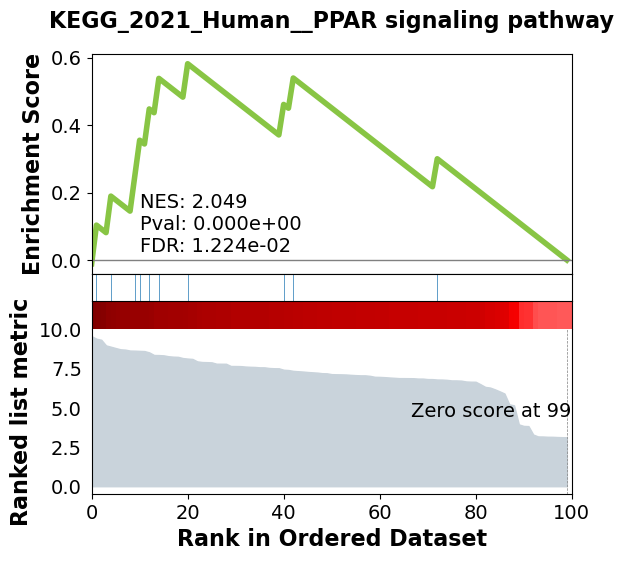

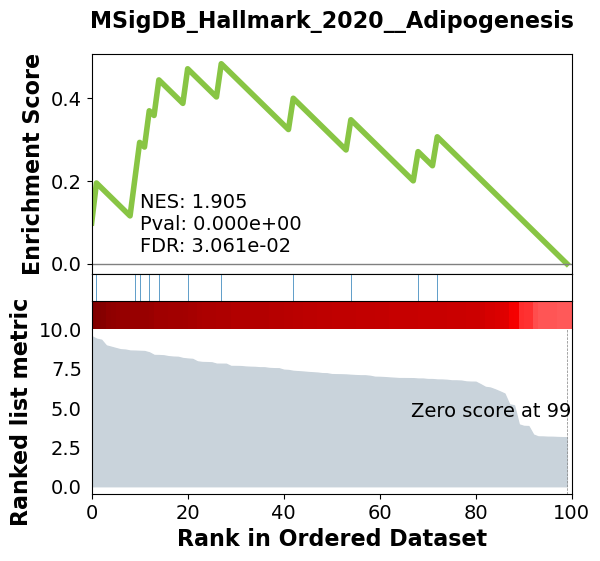

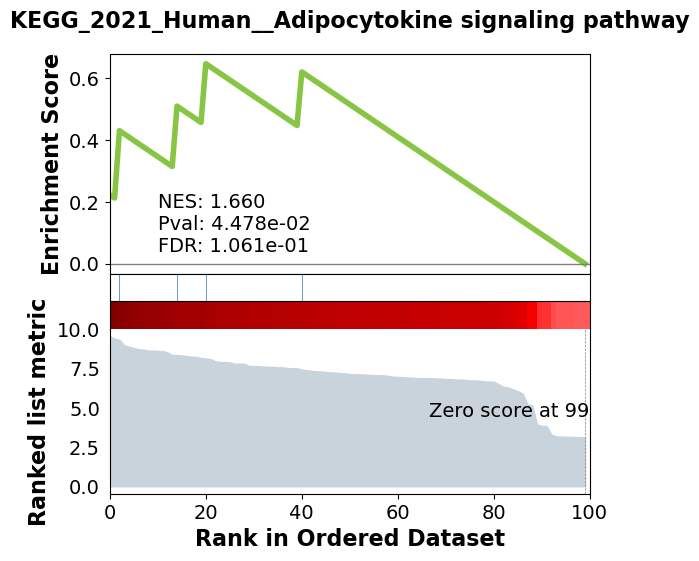

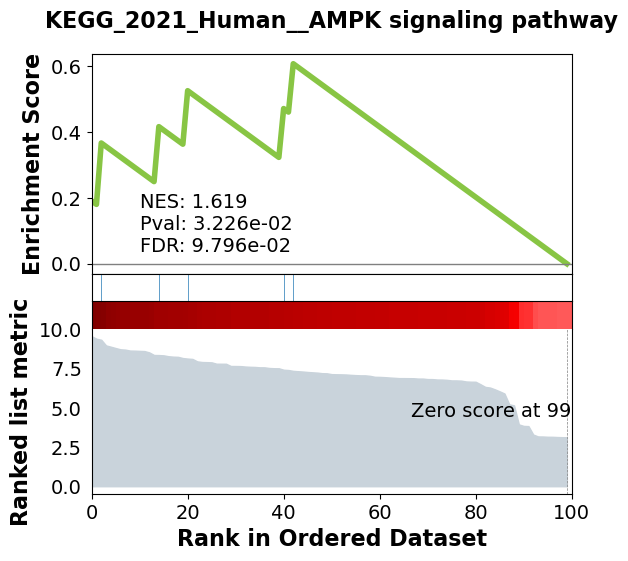

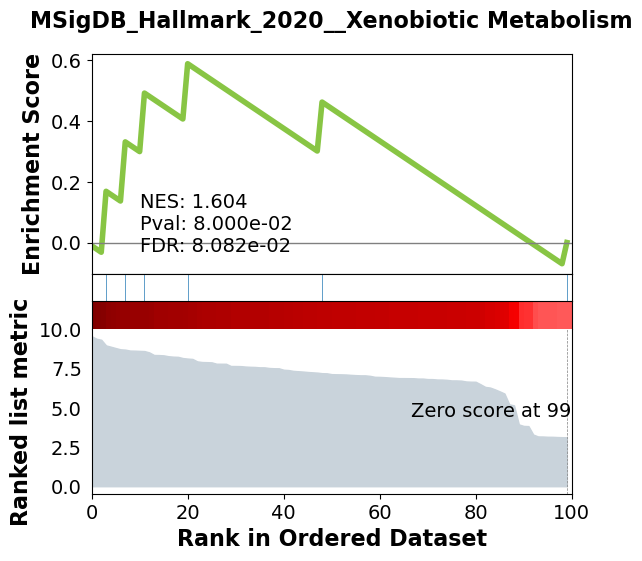

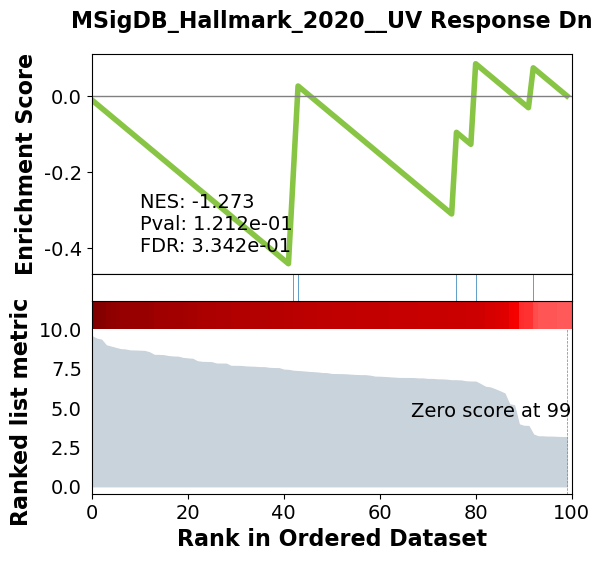

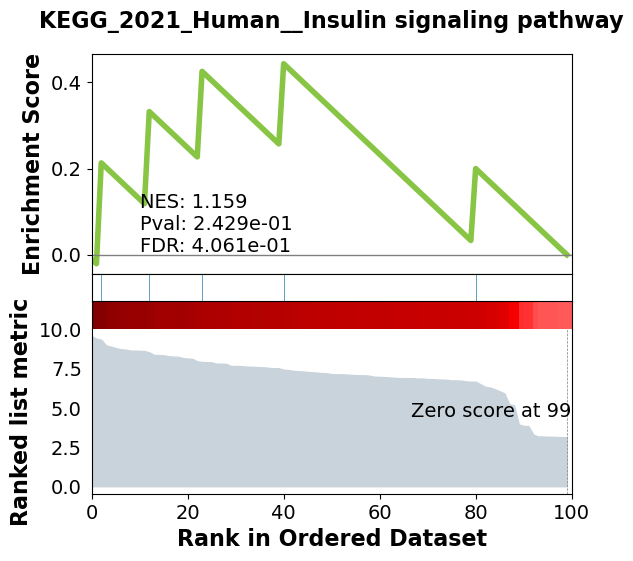

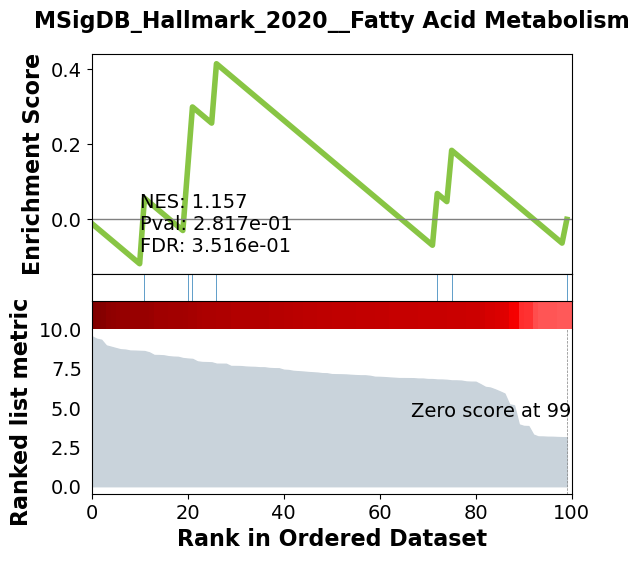

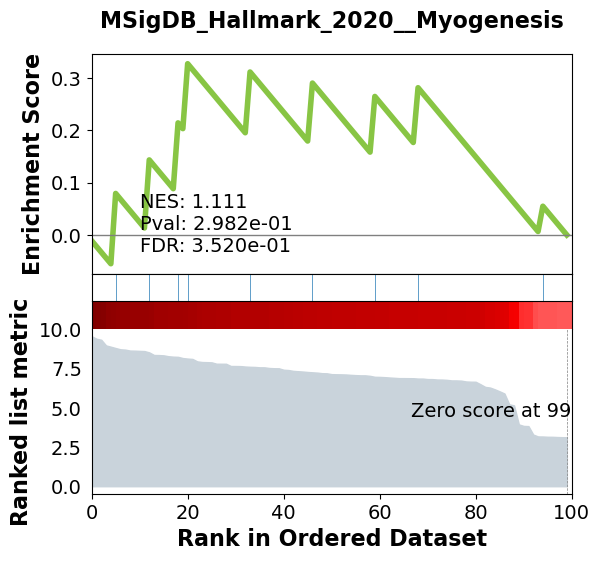

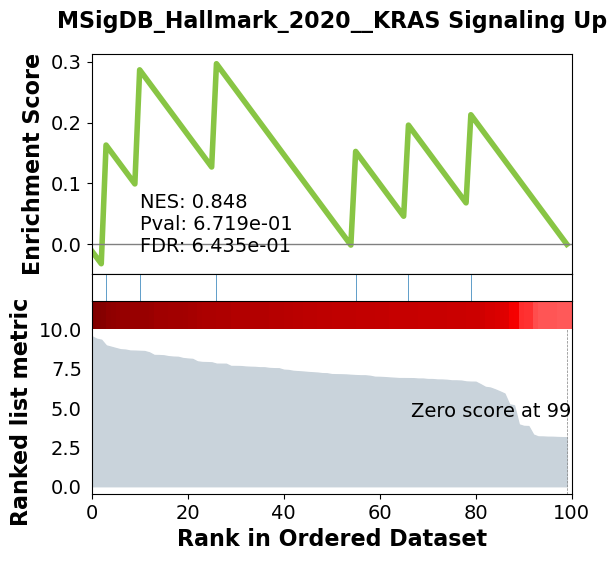

In [26]:
terms = pre_res.res2d.Term

for itr in range(10): 
    gp.gseaplot(rank_metric=pre_res.ranking,
         term=terms[itr],
         **pre_res.results[terms[itr]])
plt.show()

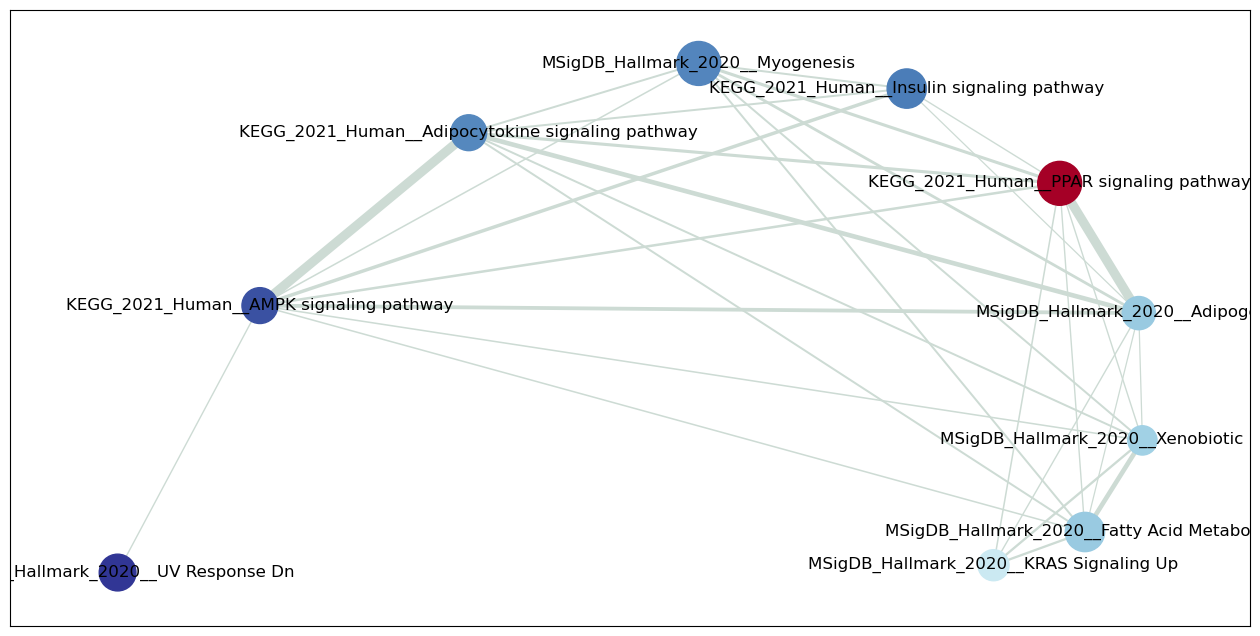

In [27]:
nodes, edges = gp.enrichment_map(pre_res.res2d, cutoff=0.9)

G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])
fig, ax = plt.subplots(figsize=(16, 8))

pos = nx.layout.spiral_layout(G)

nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.RdYlBu,
                       node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000))

nx.draw_networkx_labels(G,
                        pos=pos,
                        labels=nodes.Term.to_dict())

edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*10, edge_weight)),
                       edge_color='#CDDBD4')
plt.show()

So to sum up:
- I have found 2745 possible genes that had a statistically significant different expression between regular and cancerous tissues; among these:
    - $\textbf{LEP}$: (Leptin) overexpression of leptin is observed in about 92% of breast cancers but in no normal epithelium; (M. Ishikawa, J. Kitayama, H. Nagawa; Enhanced Expression of Leptin and Leptin Receptor (OB-R) in Human Breast Cancer. Clin Cancer Res 1 July 2004; 10 (13): 4325–4331)
    - $\textbf{LPL}$: (Lipoprotein Lipase) selected breast cancer and sarcoma cells express and secrete active LPL. In addition to de novo lipogenesis, cancer cells can use LPL to acquire fatty acids from the circulation by lipolysis, and this can fuel their growth (N. B. Kuemmerle, E. Rysman, P. S. Lombardo, A. J. Flanagan, B. C. Lipe, W. A. Wells, J. R. Pettus, H. M. Froehlich, V. A. Memoli, P. M. Morganelli, J. V. Swinnen, L. A. Timmerman, L. Chaychi, C. J. Fricano, B. L. Eisenberg, W. B. Coleman, W. B. Kinlaw; Lipoprotein Lipase Links Dietary Fat to Solid Tumor Cell Proliferation. Mol Cancer Ther 1 March 2011; 10 (3): 427–436.)
    - $\textbf{ACACB}$: low expression of ACACB has been reported in triple negative breast cancer; (K. Bhattacharjee, M. Nath, Y. Choudhury, Fatty acid synthesis and cancer: Aberrant expression of the ACACA and ACACB genes increases the risk for cancer, Meta Gene, Vol. 26,2020, 100798,ISSN 2214-5400)
    - $\textbf{RBP4}$: is a retinol binding protein which low expression implies that Vitamin A action is mitigated in cancer tissues (I have not found a lot of literature about RBP4 and breast cancer)
    - $\textbf{PLIN1}$: (Perilipin-1) PLIN1 expression is significantly downregulated in human breast cancer. Patients presenting with reduced PLIN1 expression exhibited poorer overall metastatic relapse-free survival. It's also demonstrated that the exogenous expression of PLIN1 in human breast cancer MCF-7 and MDA-MB-231 cells significantly inhibits cell proliferation, migration, invasion and in vivo tumorigenesis in mice (Zhou C., Wang M., Zhou L., Zhang Y., Liu W., Qin W., He R., Lu Y., Wang Y., Chen X., Tang J. Prognostic significance of PLIN1 expression in human breast cancer. Oncotarget. 2016; 7: 54488-54502);
    - $\textbf{BIN1}$: (Bridging integrator 1) is a ubiquitous adaptor protein with the features of a tumor suppressor mediating apoptosis by c-MYC. Complete or partial losses of BIN1 contained in breast and prostate cancers have been reported (Kuznetsova EB, Kekeeva TV, Larin SS, Zemlyakova VV, Khomyakova AV, Babenko OV, Nemtsova MV, Zaletayev DV, Strelnikov VV. Methylation of the BIN1 gene promoter CpG island associated with breast and prostate cancer. J Carcinog.);
    - $\textbf{AKR1C2}$ (Aldo-Keto Reductase Family 1 Member C2)  loss of AKR1C2 in breast cancer results in decreased progesterone catabolism, which, in combination with increased progesterone expression, may augment progesterone signaling by its nuclear receptors.
    
- Thanks to enrichment analysis I subsequently found processes and pathway that may be involved in breast cancerization:
    - $\textbf{PPAR signaling pathway}$: Peroxisome proliferator-activated receptor (PPAR) is a ligand-dependent transcription factor expressed in many tumors including breast cancer, and its function upon binding of ligands has been linked to the tumor development, progression and metastasis (Augimeri G, Giordano C, Gelsomino L, Plastina P, Barone I, Catalano S, Andò S, Bonofiglio D. The Role of PPARγ Ligands in Breast Cancer: From Basic Research to Clinical Studies. Cancers (Basel). 2020 Sep 14;12(9):2623. doi: 10.3390/cancers12092623. PMID: 32937951; PMCID: PMC7564201.).
    - $\textbf{Adipogenesis}$: Adipogenesis score was low in triple-negative (TNBC) and basal subtype breast cancer and high adipogenesis score is significantly associated with worse survival in TNBC (Oshi, M., Tokumaru, Y., Angarita, F.A. et al. Adipogenesis in triple-negative breast cancer is associated with unfavorable tumor immune microenvironment and with worse survival. Sci Rep 11, 12541 (2021).).
    - $\textbf{Myogenesis}$: I have not found literature concerning this link.
    - $\textbf{AMPK}$: Downregulation of AMPK activity or decreased level involved in the promotion of breast tumorigenesis, and thus activation of AMPK found to oppose tumor progression (L. Ponnusamy, S. Natarajan, K. Thangaraj, R. Manoharan, Therapeutic aspects of AMPK in breast cancer: Progress, challenges, and future directions, Biochimica et Biophysica Acta (BBA) - Reviews on Cancer, Volume 1874, Issue 1, 2020, 188379, ISSN 0304-419X).

From the enrichment map we can notice how AMPK, PPAR signaling, Adipogenesis and Adipocytokine have a high centrality and thus this makes them really relevant processes in breast cancerization.

About Adypocytokine signaling and insulin signaling it seems like Obesity, adipocytokines, and insulin resistance in breast cancer are, indeed, really well known matters in oncology.

For future researches, it seems like literature lacks of connection between breast cancer and myogenesis or myoblasts in general.